In [1]:
import warnings
import os
import sys
from sys import platform
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from utils import get_ds_statistics, get_model_type

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# data gathering
_config = get_global_config()

DATA_PATH = os.path.join(BASE_PATH, _config.get('DATASET_PATH'))
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH_SHARED'))
DATASET_FILE = os.path.join(BASE_PATH, _config.get('DATASET_FILE'))
if platform == 'win32':
	DATA_PATH = DATA_PATH.replace('/', '\\')
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')
	DATASET_FILE = DATASET_FILE.replace('/', '\\')
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'


data = pd.DataFrame({
	# Related to dataset
    'n_users': [],
    'n_items': [],
    'n_inter': [],
    'sparsity': [],

    # Related to KG dataset
	'kg_entities': [],
	'kg_relations': [],
	'kg_triples': [],
	'kg_items': [],

	# Related to hardware
    'cpu_cores': [],
    'ram_size': [],
    'is_gpu': [],

	# Related to model
	'model_name': [],
    'model_type': [],
    

	# Label
	'emissions': []
})

# get data
experiments = []
for d in next(os.walk(RESULTS_PATH))[1]:
	for m in next(os.walk(RESULTS_PATH + d))[1]:
		experiments.append(os.path.join(d, m))
experiments = sorted(experiments)
for i, v in enumerate(experiments):
	e = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))
 
	dataset = v.split("/")[0]
	model = v.split("/")[1]
	stats = get_ds_statistics(os.path.join(DATA_PATH, dataset))
	for _, row in e.iterrows():
		data.loc[len(data)] = [
			stats['n_users'],
			stats['n_items'],
			stats['n_inter'],
			stats['sparsity'],
			stats['kg_entities'],
			stats['kg_relations'],
			stats['kg_triples'],
			stats['kg_items'],
			row['cpu_count'],
			row['ram_total_size'],
			row['gpu_count'] if row['gpu_count'] == 1. else .0,
			model,
			get_model_type(model),
			row['emissions'],
		]

# save to file - comment to avoid doing that several times
# data.to_csv(DATASET_FILE, index=False, encoding='utf-8')
# data.to_csv('../regressor_data/regressor_input.csv', encoding='utf-8')

In [3]:
# read data
data = pd.read_csv('../regressor_data/regressor_input.csv')

# from kg to g
data['emissions'] = data['emissions']*1000

# compute tresholds for the 3 classes
interval = (data['emissions'].max() + data['emissions'].min()) / 3
low_bound = data['emissions'].min() + interval
high_bound = data['emissions'].max() - interval
max_value = data['emissions'].max()
min_value = data['emissions'].min()
avg_value = data['emissions'].mean()

print(max_value)
print(min_value)
print(avg_value)
print(low_bound)
print(high_bound)

# plot data 
fig, axs = plt.subplots(1, 1, figsize=(14, 8))
axs.scatter(range(len(data['emissions'])), data['emissions'], s=80)
axs.hlines(low_bound, 0, len(data['emissions']), colors='r')
axs.hlines(high_bound, 0, len(data['emissions']), colors='r')
axs.set_title('Emissions by models', fontsize=18)
axs.set_xlabel('Models', fontsize=14)
axs.set_ylabel('Emissions (g)', fontsize=18)
fig.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'regressor_data/regressor_input.csv'

In [104]:
# Turn categorical features into numerical
data.loc[data['model_type'] == 'general', 'model_type'] = 0
data.loc[data['model_type'] == 'knowledge', 'model_type'] = 1
mymap = sorted(list(set(data['model_name'])))
for _, v in enumerate(mymap):
	data.loc[data['model_name'] == v, 'model_name'] = mymap.index(v)


# copy of the data for the class analysis
data_class = data.copy()
data_class.loc[data_class['emissions'] >= high_bound, 'emissions'] = 2
data_class.loc[(data_class['emissions'] >= low_bound) & (data_class['emissions'] < high_bound), 'emissions'] = 1
data_class.loc[data_class['emissions'] < low_bound, 'emissions'] = 0

## Models definition

In [105]:
X = data.loc[:, data.columns != 'emissions']
y = data[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .9,
    test_size = .1,
    random_state = 2,
    shuffle = True
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

REGRESSOR                MAE              RMSE              MSLE

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

SVR                 0.0296920         0.0011083         0.0010553


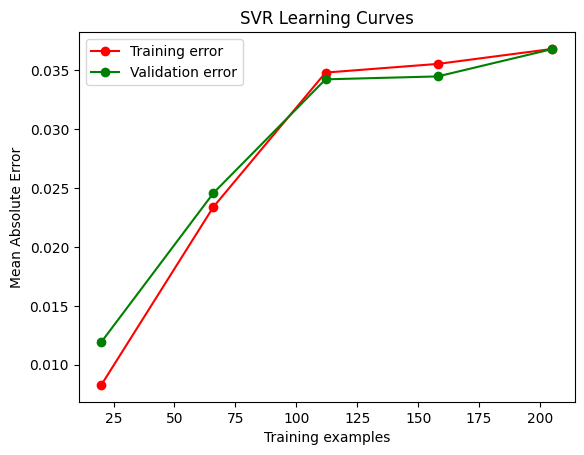


DECISION TREE       0.0091428         0.0001836         0.0001734


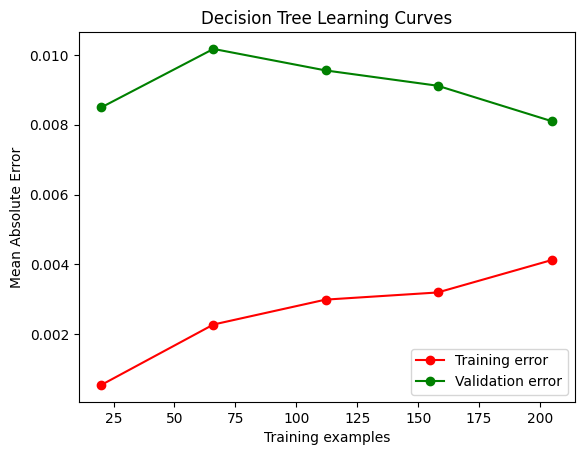


RANDOM FOREST       0.0089124         0.0001722         0.0001627


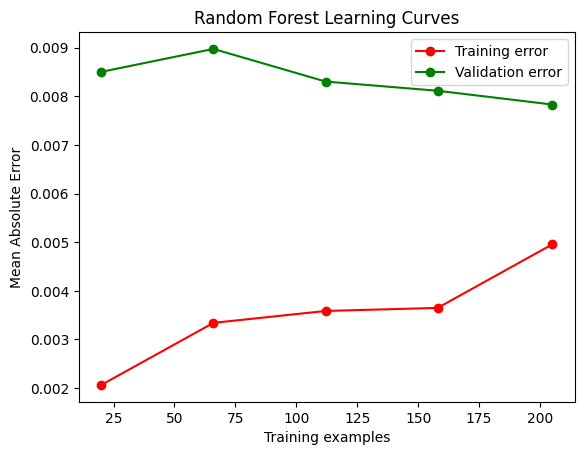


ADABOOST            0.0093535         0.0001757         0.0001661


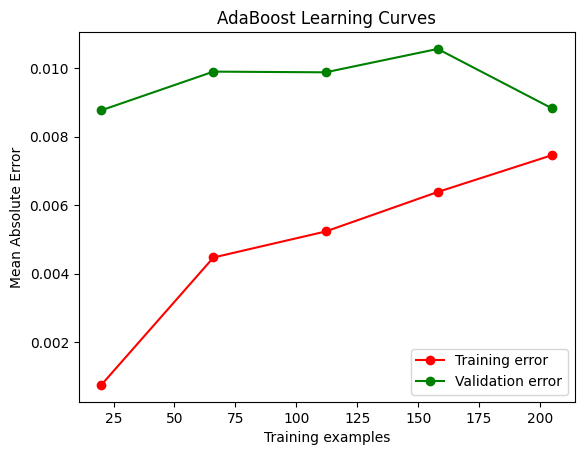

In [106]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# regression models output format
print(''.join(['> ' for i in range(35)]))
print(f'\n{"REGRESSOR":<20}{"MAE":>8}{"RMSE":>18}{"MSLE":>18}\n')
print(''.join(['> ' for i in range(35)]))

##### SVR #####
model_SVR = SVR()
model_SVR.fit(X_train, y_train)
pred = model_SVR.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"SVR":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

train_sizes, train_scores, test_scores = learning_curve(model_SVR, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('SVR Learning Curves')
plt.show()



##### Decision Tree #####
model_DecisionTree = DecisionTreeRegressor(max_depth=5, random_state=3)
model_DecisionTree.fit(X_train, y_train)
pred = model_DecisionTree.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"DECISION TREE":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

train_sizes, train_scores, test_scores = learning_curve(model_DecisionTree, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('Decision Tree Learning Curves')
plt.show()



##### Random Forest #####
model_RandomForest = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=3)
model_RandomForest.fit(X_train, y_train)
pred = model_RandomForest.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"RANDOM FOREST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')


train_sizes, train_scores, test_scores = learning_curve(model_RandomForest, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('Random Forest Learning Curves')
plt.show()



##### AdaBoost #####
model_AdaBoost = AdaBoostRegressor(n_estimators=500, random_state=3)
model_AdaBoost.fit(X_train, y_train)
pred = model_AdaBoost.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"ADABOOST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

train_sizes, train_scores, test_scores = learning_curve(model_AdaBoost, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best')
plt.title('AdaBoost Learning Curves')
plt.show()



In [107]:
# function to compute the errors

def calculateError(path,columnsName,X_test,y_test,model,low_bound,high_bound):
    results = pd.DataFrame(columns=columnsName)
    for i in range(len(columnsName)):
        results[columnsName[i]] = X_test[:,i]
    results['real_value'] = y_test
    results['predicted_value'] = model.predict(X_test)
    results['abs_error'] = abs(results['real_value'] - results['predicted_value'])
    results['percentage_error'] = abs(results['abs_error']/results['real_value'])*100
    results['class'] = 0
    results.loc[results['real_value'] >= high_bound, 'class'] = 2
    results.loc[(results['real_value'] >= low_bound) & (results['real_value'] < high_bound), 'class'] = 1
    results.to_csv(path, index=False, encoding='utf-8')
    return results

def calculateMeanError(path,low_bound,high_bound):
    results = pd.read_csv(path,encoding='utf-8')
    print("high_bound",high_bound)
    print("low_bound",low_bound)
    print("Number of samples for each class")
    print(results['class'].value_counts())
    print("Mean of the percentage error for each class")
    print(results.groupby('class')['percentage_error'].mean())
    print("Mean of the absolute error for each class")
    print(results.groupby('class')['abs_error'].mean())
    

In [108]:
# compute and show the errors
columns=data.columns
columns=columns.drop('emissions')
calculateError("data/performance_error.csv",columns,X_test,y_test,model_RandomForest,low_bound,high_bound)
calculateMeanError("data/performance_error.csv",low_bound,high_bound)


high_bound 0.059518809257352256
low_bound 0.029759662206275274
Number of samples for each class
class
0    19
1     6
2     1
Name: count, dtype: int64
Mean of the percentage error for each class
class
0    22128.255550
1       45.265002
2       43.813028
Name: percentage_error, dtype: float64
Mean of the absolute error for each class
class
0    0.004713
1    0.019185
2    0.027070
Name: abs_error, dtype: float64


In [109]:
# reshape class data
X = data_class.loc[:, data_class.columns != 'emissions']
y = data_class[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .9,
    test_size = .1,
    random_state = 2,
    shuffle = True,
	stratify=y
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [110]:
# compute accuracy, precision, recall, f1 for each model based on the class analysis


print(''.join(['> ' for i in range(42)]))
print(f'\n{"CLASSIFIER":<20}{"ACCURACY":>8}{"PRECISION":>18}{"RECALL":>18}{"F1_SCORE":>18}\n')
print(''.join(['> ' for i in range(42)]))
warnings.filterwarnings('ignore')
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro', labels=np.unique(pred))
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"SVR":<20}{acc:>8.5f}{prec:>18.5f}{rec:>18.5f}{f1:>18.5f}')

model = DecisionTreeClassifier(max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"DECISION TREE":<20}{acc:>8.5f}{prec:>18.5f}{rec:>18.5f}{f1:>18.5f}')

model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"RANDOM FOREST":<20}{acc:>8.5f}{prec:>18.5f}{rec:>18.5f}{f1:>18.5f}')

model = AdaBoostClassifier(n_estimators=20, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"ADABOOST":<20}{acc:>8.5f}{prec:>18.5f}{rec:>18.5f}{f1:>18.5f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

CLASSIFIER          ACCURACY         PRECISION            RECALL          F1_SCORE

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

SVR                  0.88462           0.48551           0.70833           0.47872

DECISION TREE        0.88462           0.33333           0.30667           0.31944

RANDOM FOREST        0.84615           0.31884           0.30556           0.31206

ADABOOST             0.76923           0.28986           0.30303           0.29630
